# Working with Markov Chains
### Andres Perez Martinez
(4.75/5)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numpy.linalg import matrix_power  #need this for powers of the Markov matrix
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import quantecon as qe
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

### Load AutoReg class from statsmodels.tsa.ar_model module

from statsmodels.tsa.ar_model import AutoReg
### Load and plot the time-series data

from statsmodels.graphics.tsaplots import plot_pacf

### Part 1.-
#### Import the Weekly Economic Index from FRED.  Plot it, and make it a data frame.

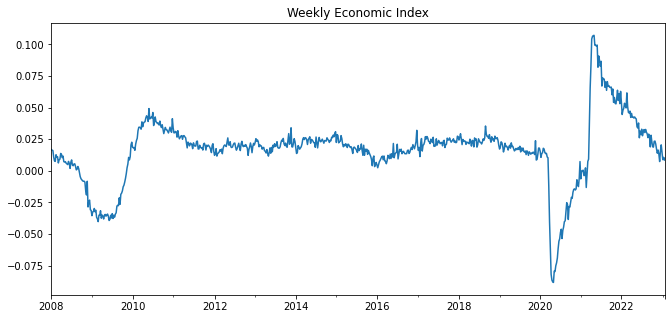

In [2]:
from fredapi import Fred

fred =Fred(api_key= '6c0ecd6565503b64631fd2b36f71293a')                       #Need the key
WEI = fred.get_series('WEI')/100 #weekly
WEI.plot(title = "Weekly Economic Index")

PS4 = pd.DataFrame(WEI, columns = ['WEI'])

### Part 2.- 
#### Use the Augmented Dickey Fuller Test to see if the index is stationary.   Plot the partial autocorrelations out to 25 lags. 

P-value:  0.011497628684729122
The data are stationarity.


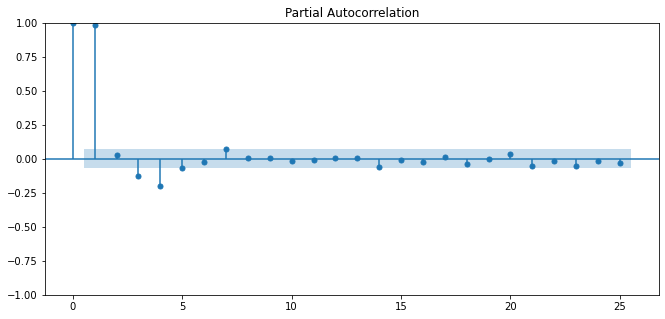

In [3]:
from statsmodels.tsa.stattools import adfuller


df_stationarityTest = adfuller(PS4['WEI'], autolag = 'AIC')

print('P-value: ', df_stationarityTest[1])

if df_stationarityTest[1] >= 0.05:
    print("The data have a unit root.")
else:
    print("The data are stationarity.")

pacf = plot_pacf(PS4['WEI'], method = 'ywm', lags = 25)

In [4]:
nlags = 1

ar_model = AutoReg(PS4['WEI'], lags=nlags).fit()

print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                    WEI   No. Observations:                  787
Model:                     AutoReg(1)   Log Likelihood                3107.743
Method:               Conditional MLE   S.D. of innovations              0.005
Date:                Mon, 06 Feb 2023   AIC                          -6209.486
Time:                        22:00:35   BIC                          -6195.485
Sample:                    01-12-2008   HQIC                         -6204.103
                         - 01-28-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.398      0.162      -0.000       0.001
WEI.L1         0.9829      0.007    149.388      0.000       0.970       0.996
                                    Roots           

D:\Applications\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


### Part 3.-
#### Plot a histogram of the data, and return the counts, bins, and patches.  

The edges of the bins are ...
[-0.0883  -0.06876 -0.04922 -0.02968 -0.01014  0.0094   0.02894  0.04848
  0.06802  0.08756  0.1071 ]

Here are the counts of the number of states in each bin ...
<generator object <genexpr> at 0x00000260FB2249E0>

All is well with the count data


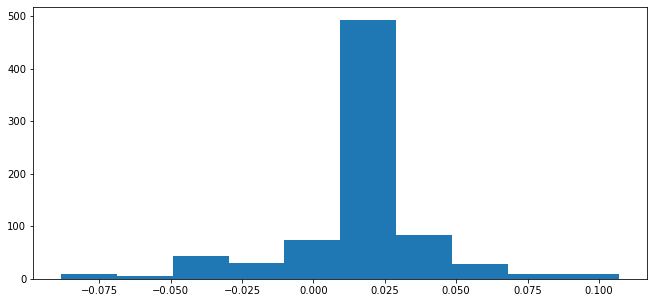

In [5]:
(counts, bins, patches) = plt.hist(WEI)

print("The edges of the bins are ...")
print(bins)
print("")
print("Here are the counts of the number of states in each bin ...")
print(int(x) for x in counts)
print("")


if np.sum(counts) != len(WEI):
    print("We have lost some data.")
else:
    print("All is well with the count data")


### Part 4.-
#### Classify the data into states, corresponding to the intervals  between the bins.

In [6]:
state_numbers = list(range(len(bins)-1)) 
state_names = ["Catastrophe", "Andres and Javier (Criminal)", "Very Bad", "Bad",
               "OK", "Alright, I guess", "Very Good", "Excellent", "Almost the Best", "Dr. Fisher (The Best)"]  #Number next to name will help us later if we forget the order

def classify(x,bins,states):
    """
    x is the data
    bins gives the break points
    states are the names of the states
    """
    n=len(bins) # the number of edges of the bins is one more than the number of states
    conditions = []
    for i in range(n-1): #define an array of logical conditions
        conditions.append((x <= bins[i+1]) & (x >= bins[i]))
    return(np.select(conditions, states))

PS4.insert(1,"State Numbers", classify(PS4['WEI'],bins,state_numbers))

In [7]:
n = len(WEI)
y = []
for i in range(n):
    y.append(state_names[int(PS4["State Numbers"][i])])

PS4.insert(2, "State Names",y)
print("The last eight rows of the GDP cycle data and thier states are:")

PS4.tail(8)

The last eight rows of the GDP cycle data and thier states are:


,WEI,State Numbers,State Names
2022-12-10,0.0073,4,OK
2022-12-17,0.0157,5,"Alright, I guess"
2022-12-24,0.0205,5,"Alright, I guess"
2022-12-31,0.0148,5,"Alright, I guess"
2023-01-07,0.0088,4,OK
2023-01-14,0.0106,5,"Alright, I guess"
2023-01-21,0.0084,4,OK
2023-01-28,0.0099,5,"Alright, I guess"


### Part 5.-
#### Group the data by the mean within each state.  This has the interpretation as the mean growth rate in that state.

In [8]:
g = PS4.groupby(by=["State Numbers"])[['WEI']].mean()
g.insert(1, "State Names", state_names)
g                                                     #show it

,WEI,State Names
State Numbers,,
0,-0.080022,Catastrophe
1,-0.057020,Andres and Javier (Criminal)
2,-0.036467,Very Bad
3,-0.019923,Bad
4,0.002934,OK
5,0.019718,"Alright, I guess"
6,0.036205,Very Good
7,0.058983,Excellent
8,0.078080,Almost the Best


### Part 6.-
#### Estimate the Markov matrix. 

In [9]:
dim =len(bins)-1
def estimate_markov(x,dim):
    n=len(x)
    m = np.zeros((dim,dim))
    for i in range (n-1):
        m[int(x[i]), int(x[i+1])] +=1
    row_sums = sum(m.T)
    m = m/row_sums[:,None]
    return(m)

P=estimate_markov (PS4['State Numbers'],dim)
print('The Markov matrix is \n',P)

The Markov matrix is 
 [[0.88888889 0.11111111 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.2        0.4        0.4        0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.04651163 0.88372093 0.06976744 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.09677419 0.74193548 0.16129032 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.05405405 0.75675676 0.17567568
  0.01351351 0.         0.         0.        ]
 [0.         0.         0.         0.00203252 0.02642276 0.94715447
  0.02439024 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.1547619
  0.80952381 0.03571429 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.10344828 0.75862069 0.13793103 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.4        0.4        0.2

### Part 7
#### Check if the chain is aperiodic and irreducible.  Find its communication classes.

In [10]:
mc = qe.MarkovChain(P, state_values=state_names)  #define markov chain

if mc.is_irreducible:
    print("The Markov chain is irreducible.")
if mc.is_aperiodic:
    print("The Markov chain is aperiodic.")

print("The communications classes are: ", mc.communication_classes)

The Markov chain is irreducible.
The Markov chain is aperiodic.
The communications classes are:  [array(['Catastrophe', 'Andres and Javier (Criminal)', 'Very Bad', 'Bad',
       'OK', 'Alright, I guess', 'Very Good', 'Excellent',
       'Almost the Best', 'Dr. Fisher (The Best)'], dtype='<U28')]


### Part 8.-
#### Find the ergodic distribution of states.  Is it unique?

In [11]:
print("The ergodic distribution of state is: \n", mc.stationary_distributions)

The ergodic distribution of state is: 
 [[0.01145038 0.00636132 0.05470738 0.0394402  0.09414758 0.6259542
  0.10687023 0.03689567 0.01272265 0.01145038]]


### Part 9
#### Plot a simulation of the process for two years, starting from its current value.

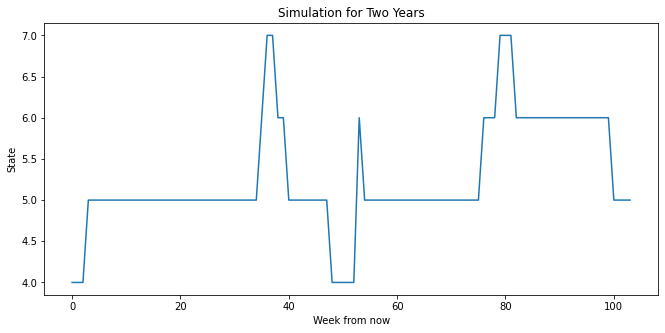

In [12]:
T= 2*52    #two years
this_week = 4
mc = qe.MarkovChain(P, state_values=state_numbers)
X = mc.simulate_indices(ts_length = T, init = this_week)

plt.plot(X)
plt.ylabel("State")
plt.xlabel("Week from now")
plt.title("Simulation for Two Years")
plt.show()

In [13]:
mc = qe.MarkovChain (P, state_values = state_numbers)
T = 2*25
N = 100_000 

count = 0
for i in range(N):
    X = mc.simulate(ts_length = T, init = this_week)
    if np.mean(X == 0) != 0:
        count += 1 
print(count/N)

0.03476


### Part 10.-
####  Calculate the mean hitting time between occurrences of the worst state.

In [14]:
from numpy.linalg import inv 
A = P[1:, 1:]
print('The meaning hitting time for the return to a covid lockdown is', 
      np.around((np.linalg.inv(np.identity(9)-A)@np.ones(9))[this_week-1],0),'weeks')

The meaning hitting time for the return to a covid lockdown is 1546.0 weeks


### Part 11

In [15]:
p = P[this_week,:]
for t in range(104):
    p[0] = 0.0
    p = p@P
    prob = np.sum(p[1:])
    
print('The probability that Biden hits another Covid State is', np.around(1-prob,5), ', damn you Biden!')

The probability that Biden hits another Covid State is 0.0699 , damn you Biden!


### Part 12
#### What is the probability that we will see another Covid state in the next two years?

P-Value: 6.869702320994563e-08
The data are stationary


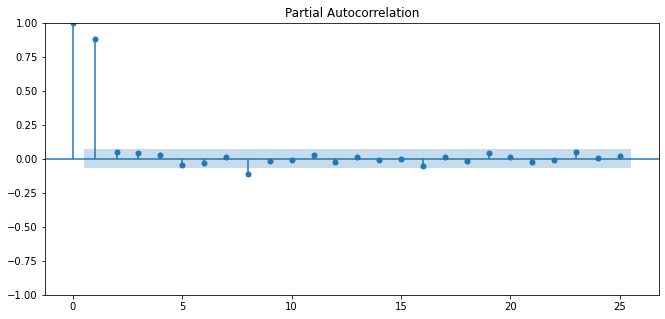

In [16]:
T = len(WEI)
mc = qe.MarkovChain(P,state_values = state_numbers)
X = mc.simulate_indices(ts_length=T, init = this_week)
Y = g["WEI"][X]

from statsmodels.tsa.stattools import adfuller 

stationarityTest = adfuller(Y, autolag = 'AIC')

print("P-Value:", stationarityTest[1])

if df_stationarityTest[1] > 0.05:
    print("The data have a unit root")
else: 
    print("The data are stationary")
    
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(Y, method ='ywm', lags = 25)

In [17]:
nlags = 1
ar_model = AutoReg(Y, lags = nlags).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                    WEI   No. Observations:                  787
Model:                     AutoReg(1)   Log Likelihood                2976.895
Method:               Conditional MLE   S.D. of innovations              0.005
Date:                Mon, 06 Feb 2023   AIC                          -5947.790
Time:                        22:00:40   BIC                          -5933.789
Sample:                             1   HQIC                         -5942.407
                                  787                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.000      6.249      0.000       0.002       0.003
WEI.L1         0.8830      0.017     53.125      0.000       0.850       0.916
                                    Roots           

D:\Applications\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [18]:
from tabulate import tabulate 

value = round(ar_model.params['WEI.L1'],4)
std_err = round(ar_model.bse['WEI.L1'],4)
coef_estimate = f"{value} ({std_err})"



table = [['Comparator', 'Data', 'Simulation'],
        ['N', 784, 784],
        ['ADF imply stationary?', 'Yes', 'Yes'],
        ['AR1 coefficient estimate (standard error)', "0.9829(0.007)", coef_estimate]]

print(tabulate(table,headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═══════════════════════════════════════════╤═══════════════╤════════════════╕
│ Comparator                                │ Data          │ Simulation     │
╞═══════════════════════════════════════════╪═══════════════╪════════════════╡
│ N                                         │ 784           │ 784            │
├───────────────────────────────────────────┼───────────────┼────────────────┤
│ ADF imply stationary?                     │ Yes           │ Yes            │
├───────────────────────────────────────────┼───────────────┼────────────────┤
│ AR1 coefficient estimate (standard error) │ 0.9829(0.007) │ 0.883 (0.0166) │
╘═══════════════════════════════════════════╧═══════════════╧════════════════╛
